<a href="https://colab.research.google.com/github/rickqiu/deep-learning/blob/master/tensorflow2_mobilenets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow2 - MobileNets: A Pre-trained Multiclass Classifier

MobileNets are lightweight deep neural networks that are suitable for mobile and embedded vision applications (Howard et al., 2017). Computer Vision (CV) engineers often utilize transfer learning techniques to perform CV tasks with pre-trained convolutional neural networks (CNN). 

Keras Fashion-MNIST is a toy dataset which consists of images of clothing. The data has a training set of 60,000 28x28 grayscale images of 10 fashion categories, along with a testing set of 10,000 images. A dictionary key is defined below with the corresponding class name for each of the integer encoded values in y_train and y_test.

In [0]:
key = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat", 5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input,Reshape,Dense,Lambda,GlobalAveragePooling2D
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

## Data preprocessing

In [9]:
# Load data sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
# Set the input image dimension
height,width = 128,128

# Resize the image size to (128, 128)
X_train = X_train.reshape((-1, 28, 28))
X_train = np.array([cv2.resize(x, dsize=(height, width)).astype(float) for x in X_train])
X_train = X_train.reshape((X_train.shape[0], height, width, 1))

X_test = X_test.reshape((-1,28,28))
X_test = np.array([cv2.resize(x, dsize=(height, width)).astype(float) for x in X_test])
X_test = X_test.reshape((X_test.shape[0], height, width, 1))

In [0]:
# One-hot encoding on y
y_binary_train = tf.one_hot(y_train,10)
y_binary_test = tf.one_hot(y_test,10)

In [0]:
# Define Image Data Generator for training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   shear_range=0.1,
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

# Define Image Generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

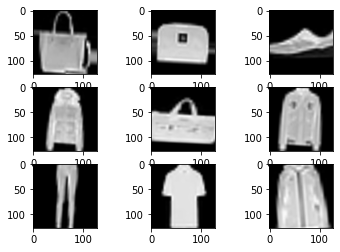

In [13]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in train_datagen.flow(X_train, y_binary_train, batch_size=9, seed=42):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(height, width), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break	

## Modelling

In [0]:
# Define mobile networks
def mobile_net(height, width):
  
  # Define Input layer
  input = Input(shape=(height, width, 1))
  
  # Add a Reshape layer
  input_image = Reshape((height, width), input_shape=(height, width, 1))(input)
  
  # Add Lambda layer to expand the image to 3 channels
  input_image = Lambda(lambda x: K.repeat_elements(K.expand_dims(x,3),3,3))(input_image)
  
  # Create MobileNets base model with pre-trained weights
  base_model = MobileNet(input_shape=(height, width, 3),
                         input_tensor=input_image, 
                         weights='imagenet', 
                         include_top=False)

  # Add a global average pooling layer
  x = GlobalAveragePooling2D()(base_model.output)
  
  # Add output layer
  output = Dense(10, activation='softmax')(x)

  model = Model(inputs=input, outputs=output)
  return model

In [17]:
# Instantiate a model
model = mobile_net(height, width)
# Show model summary
model.summary()
#plot_model(model, to_file='mobile_net.png', show_shapes=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 128)          0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0   

## Model training

In [18]:
# Train the model
opt=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="mobile_net.h5",
                               verbose=0,
                               save_best_only=True)

history = model.fit(train_datagen.flow(X_train, y_binary_train, batch_size=32, seed=42), 
                    validation_data=test_datagen.flow(X_test, y_binary_test, batch_size=32, seed=42),
                    callbacks=[checkpointer],
                    epochs = 50)

Epoch 1/50
1875/1875 [==============================] - 103s 55ms/step - loss: 0.3613 - accuracy: 0.8750 - val_loss: 0.3055 - val_accuracy: 0.8943
Epoch 2/50
1875/1875 [==============================] - 100s 53ms/step - loss: 0.2450 - accuracy: 0.9121 - val_loss: 0.2368 - val_accuracy: 0.9134
Epoch 3/50
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2220 - accuracy: 0.9199 - val_loss: 0.2218 - val_accuracy: 0.9178
Epoch 4/50
1875/1875 [==============================] - 100s 54ms/step - loss: 0.2020 - accuracy: 0.9266 - val_loss: 0.1993 - val_accuracy: 0.9268
Epoch 5/50
1875/1875 [==============================] - 100s 53ms/step - loss: 0.1824 - accuracy: 0.9348 - val_loss: 0.1974 - val_accuracy: 0.9281
Epoch 6/50
1875/1875 [==============================] - 99s 53ms/step - loss: 0.1706 - accuracy: 0.9378 - val_loss: 0.1805 - val_accuracy: 0.9369
Epoch 7/50
1875/1875 [==============================] - 99s 53ms/step - loss: 0.1590 - accuracy: 0.9414 - val_loss: 0.20

In [0]:
# Plot learning curves
def plot_learning_curves(history):
    plt.plot(history.history["accuracy"],label="Train Accuracy")
    plt.plot(history.history["val_accuracy"],label="Val Accuracy")
    plt.legend()
    plt.show()

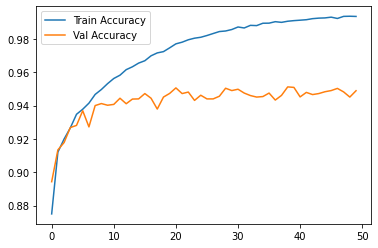

In [20]:
plot_learning_curves(history)

In [38]:
print('Results:\n')
print('The best validation accuracy is %.2f%%.' % (np.max(history.history["val_accuracy"])*100))

Results:

The best validation accuracy is 95.12%.


## Make predictions

In [0]:
# Load the pre-trained mobile_net model
model = load_model('/content/mobile_net.h5')

1/1 [==============================] - 0s 990us/step
[6 3 0 5 2 5 9 5 6 3 8 1 0 3 9 6 7 2 9 8 4 0 8 1 8 8 1 5 7 4 2 4]


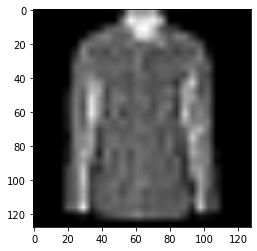

Predicted Label:  Shirt
True Label:  Shirt
Correct


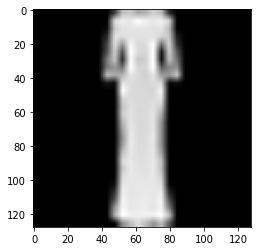

Predicted Label:  Dress
True Label:  Dress
Correct


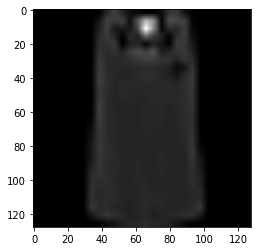

Predicted Label:  T-shirt/top
True Label:  T-shirt/top
Correct


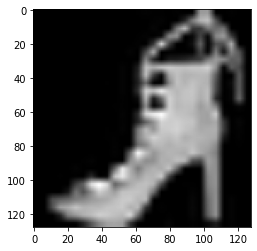

Predicted Label:  Sandal
True Label:  Sandal
Correct


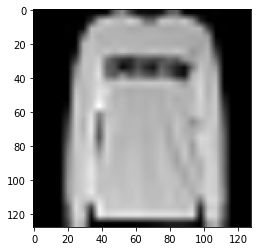

Predicted Label:  Pullover
True Label:  Pullover
Correct


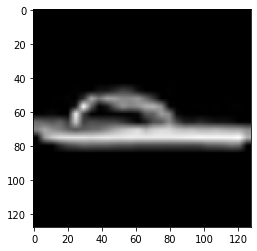

Predicted Label:  Sandal
True Label:  Sandal
Correct


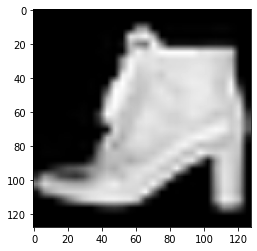

Predicted Label:  Ankle boot
True Label:  Ankle boot
Correct


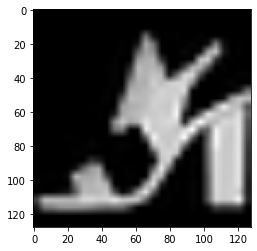

Predicted Label:  Sandal
True Label:  Sandal
Correct


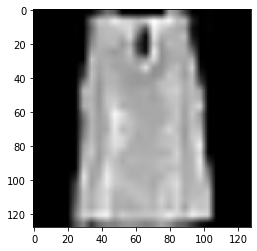

Predicted Label:  Shirt
True Label:  Shirt
Correct


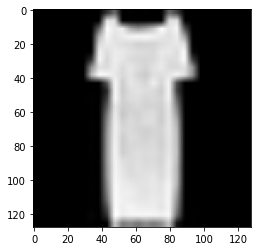

Predicted Label:  Dress
True Label:  Dress
Correct


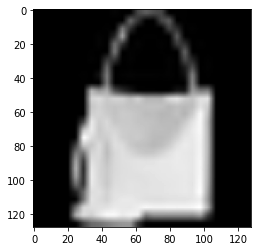

Predicted Label:  Bag
True Label:  Bag
Correct


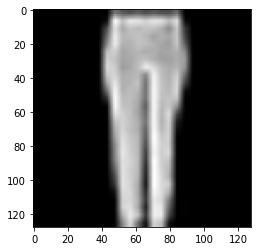

Predicted Label:  Trouser
True Label:  Trouser
Correct


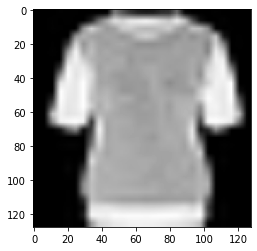

Predicted Label:  T-shirt/top
True Label:  T-shirt/top
Correct


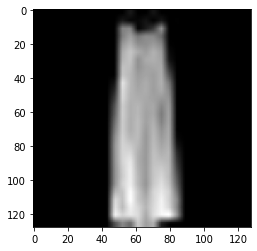

Predicted Label:  Dress
True Label:  Dress
Correct


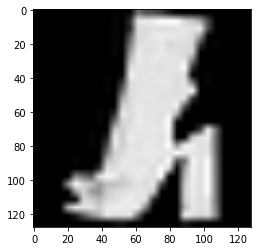

Predicted Label:  Ankle boot
True Label:  Ankle boot
Correct


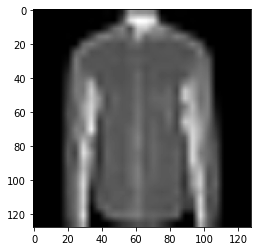

Predicted Label:  Shirt
True Label:  Shirt
Correct


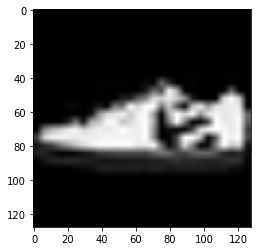

Predicted Label:  Sneaker
True Label:  Sneaker
Correct


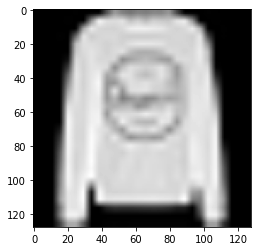

Predicted Label:  Pullover
True Label:  Pullover
Correct


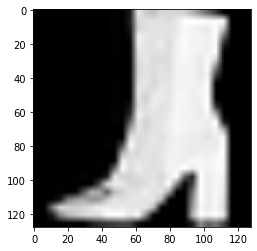

Predicted Label:  Ankle boot
True Label:  Ankle boot
Correct


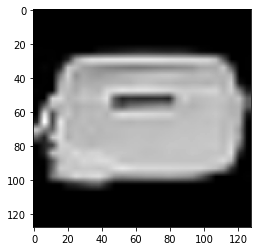

Predicted Label:  Bag
True Label:  Bag
Correct


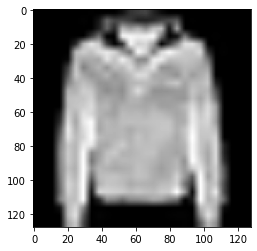

Predicted Label:  Coat
True Label:  Coat
Correct


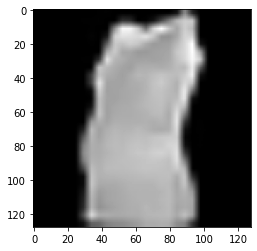

Predicted Label:  T-shirt/top
True Label:  T-shirt/top
Correct


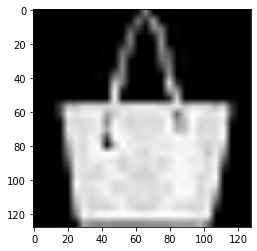

Predicted Label:  Bag
True Label:  Bag
Correct


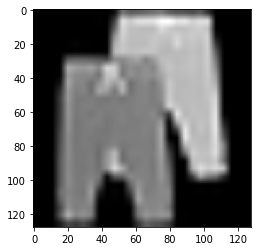

Predicted Label:  Trouser
True Label:  Trouser
Correct


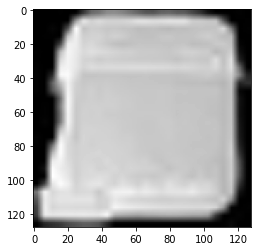

Predicted Label:  Bag
True Label:  Bag
Correct


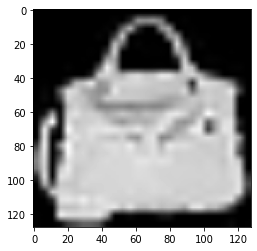

Predicted Label:  Bag
True Label:  Bag
Correct


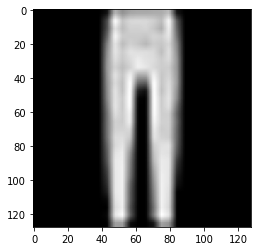

Predicted Label:  Trouser
True Label:  Trouser
Correct


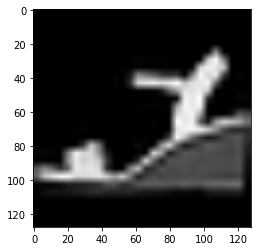

Predicted Label:  Sandal
True Label:  Sandal
Correct


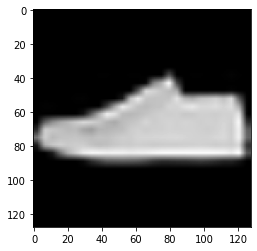

Predicted Label:  Sneaker
True Label:  Sneaker
Correct


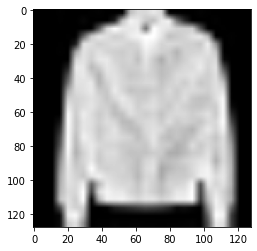

Predicted Label:  Coat
True Label:  Coat
Correct


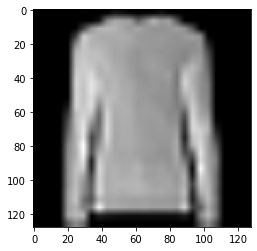

Predicted Label:  Pullover
True Label:  Pullover
Correct


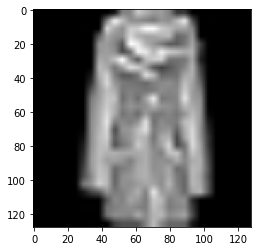

Predicted Label:  Coat
True Label:  Coat
Correct


In [40]:
# configure batch size and retrieve one batch of images
batch_size = 32

for X_batch, y_batch in test_datagen.flow(X_test, y_test, batch_size=batch_size, seed=42):

    y_pred_as_integers= np.argmax(model.predict(X_batch, batch_size=batch_size, verbose=1), axis=1)
    print( y_pred_as_integers)

    for i in range(0, batch_size):
        plt.imshow(X_batch[i].reshape(height, width), cmap=plt.get_cmap('gray'))
        
        # show the plot
        plt.show()
        
        print("Predicted Label: ",key[y_pred_as_integers[i]])
        print("True Label: ",key[y_batch[i]])
        if(y_pred_as_integers[i] == y_batch[i]):
            print("Correct")
        else:
            print("Incorrect")

    break
